## 市场宽度
*对市场内股票数据进行统计，观察样本变化。*

## 目录
1. 什么是市场宽度？
2. 数据预处理
3. 市场宽度计算公式
4. 如何用图形展示市场宽度？

## 1_什么是市场宽度？
市场宽度指标指某一日收盘时，显示某指数组合的股票的上涨数量与下跌数量的比率，有比较准确预测大盘行情的功能。

### 怎么计算市场宽度？

**1. Advance & Decline Percent (Participation)**

$\frac{(Advance-Decline)}{Total}$

**2. High & Low Percent (Leadership)**

$\frac{(High-Low)}{Total}$

**3. MA50_up & MA50_down Percent (Trend)**

$\frac{(MA50_{up}-MA50_{down})}{Total}$

## 1_Data Processing

In [1]:
import pymongo
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance', 'bnb_usdt.spot:binance', 'ltc_usdt.spot:binance','bch_usdt.spot:binance',
             'doge_usdt.spot:binance', 'matic_usdt.spot:binance', 'sol_usdt.spot:binance','link_usdt.spot:binance','uni_usdt.spot:binance']
client = pymongo.MongoClient('172.16.20.81', 27017)

In [3]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [4]:
startTime = datetime(2022,6,1)
endTime = datetime(2023,1,6)
dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [5]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName],
                'bnb':readDb(dbClient[symbolList[2]], start=startTime , end=endTime)[columnsName],
                'ltc':readDb(dbClient[symbolList[3]], start=startTime , end=endTime)[columnsName],
                'bch':readDb(dbClient[symbolList[4]], start=startTime , end=endTime)[columnsName],
                'doge':readDb(dbClient[symbolList[5]], start=startTime , end=endTime)[columnsName],
                'matic':readDb(dbClient[symbolList[6]], start=startTime , end=endTime)[columnsName],
                'sol':readDb(dbClient[symbolList[7]], start=startTime , end=endTime)[columnsName],
                'link':readDb(dbClient[symbolList[8]], start=startTime , end=endTime)[columnsName],
                'uni':readDb(dbClient[symbolList[9]], start=startTime , end=endTime)[columnsName],
            }

In [6]:
def resampleDf(data, freq='H'):
    dataDf = df.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

In [7]:
def addSymbol(dataDf, symbolName):
    dataDf['symbol'] = symbolName
    return dataDf

In [8]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [9]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [10]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [11]:
multiDf.tail(10)

open         high          low  \
datetime            symbol                                          
2023-01-05 23:00:00 bch       101.30000    102.00000    101.30000   
                    bnb       256.40000    258.40000    256.20000   
                    btc     16830.28000  16879.82000  16823.10000   
                    doge        0.07264      0.07296      0.07222   
                    eth      1248.21000   1252.75000   1247.74000   
                    link        5.71000      5.73800      5.69900   
                    ltc        74.08000     74.60000     74.02000   
                    matic       0.79020      0.79570      0.78960   
                    sol        13.17000     13.40000     13.15000   
                    uni         5.41500      5.45000      5.40100   

                                  close        volume  
datetime            symbol                             
2023-01-05 23:00:00 bch       101.60000  2.989670e+03  
                    bnb       256.80000  1.376489e+04  
                    btc     16842.94000  1.210726e+04  
                    doge        0.07237  4.403868e+07  
                    eth      1249.11000  1.659101e+04  
                    link        5.71800  1.125516e+05  
                    ltc        74.37000  2.693517e+04  
                    matic       0.79150  2.211048e+06  
                    sol        13.29000  3.035376e+05  
                    uni         5.40400  2.212952e+04

In [12]:
periodList = [24, 72, 120, 192, 312]
symbolCount = 10

In [13]:
highPrice = multiDf['high'].unstack()
lowPrice = multiDf['low'].unstack()
closePrice = multiDf['close'].unstack()

In [14]:
btcStochasticDict = {}
for hour in periodList:
    btcStochasticDict[hour] = (closePrice['btc'] - closePrice['btc'].rolling(hour).min())/(closePrice['btc'].rolling(hour).max() - closePrice['btc'].rolling(hour).min())    
btcStochastic = pd.DataFrame(btcStochasticDict)
btcStochastic.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

## Code of Breadth Indicator

In [15]:
def cal_pt(positive, total):
    return positive/total

def cal_pnPct(positive, negative, total):
    return ((positive-negative)/total+1)/2

def sumrows(frame):
    return frame.sum(axis=1)

# 1. Percent/Number of Stocks above Moving Average (Trend)

In [16]:
def cal_ma(data, timeperiod):
    return data.rolling(timeperiod).mean()
maPeriodDict = {}
for hour in periodList:
    ma = cal_ma(closePrice, hour)
    maPeriodDict[hour] = cal_pt(sumrows(closePrice>ma), symbolCount)
maUpPct = pd.DataFrame(maPeriodDict)
maUpPct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

# 2. Percent/Number of Stocks above Relative Strength

In [17]:
def cal_pct(data, period):
    return data.pct_change(period)
rsDf = pd.DataFrame({name: closePrice[name]/closePrice['btc'] for name in closePrice.columns})
rsDf['btc'] = closePrice['btc']
rsPeriodDict = {}
for hour in periodList:
    rsPeriodDict[hour] = cal_pt(sumrows(cal_pct(rsDf, hour)>0), symbolCount)
rsUpPct = pd.DataFrame(rsPeriodDict)
rsUpPct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

# 3. Periodic High and Low

In [18]:
import numpy as np
def cal_shochastic(data, period):
    return ((data - data.rolling(period).min())/(data.rolling(period).max()-data.rolling(period).min()))*100
hlRangePeriodDict = {}
for hour in periodList:
    hlRangePeriodDict[hour] = cal_pnPct(sumrows(cal_shochastic(closePrice, hour)>80), 
                                     sumrows(cal_shochastic(closePrice, hour)<20), symbolCount)
hlRangePct = pd.DataFrame(hlRangePeriodDict)
hlRangePct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

# 4. Advance/Decline(Participation)

In [19]:
def cal_pct(data, period):
    return data.pct_change(period)
adPeriodDict = {}
for hour in periodList:
    adPeriodDict[hour] = cal_pt(sumrows(cal_pct(closePrice, hour)>0), symbolCount)
adPct = pd.DataFrame(adPeriodDict)
adPct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

# 5. Net New High and Net New Lows(Leadership)

In [20]:
hlNewPeriodDict = {}
for hour in periodList:
    dh = highPrice.rolling(hour).max().pct_change()
    dl = lowPrice.rolling(hour).min().pct_change()
    hlNewPeriodDict[hour] = cal_pnPct(sumrows(dh>0), sumrows(dl<0), symbolCount)
hlNewPct = pd.DataFrame(hlNewPeriodDict)
hlNewPct.columns = ['1Day', '3Day', '5Day', '8Day', '13Day']

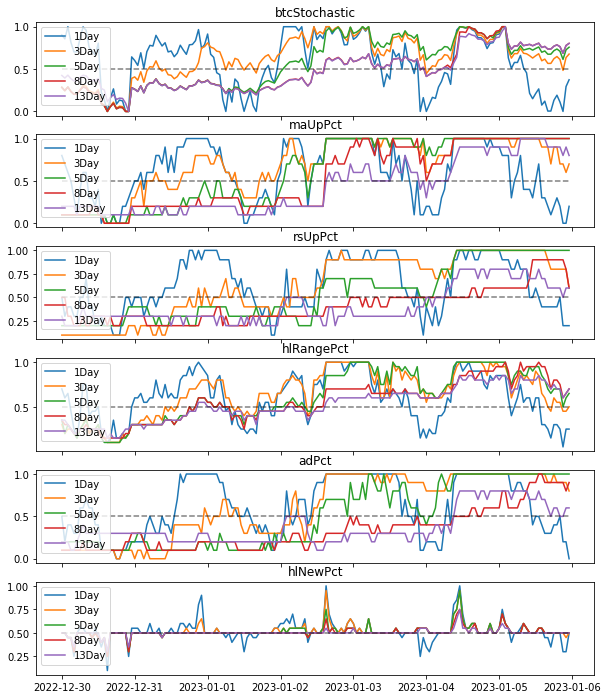

In [26]:
weeklyHour = 168
import matplotlib.pyplot as plt
fig, (ax, ax1, ax2, ax3, ax4, ax5) = plt.subplots(6, 1,sharex=True, figsize=(10,12))
ax.plot(btcStochastic.iloc[-weeklyHour:], label=btcStochastic.columns)
ax.hlines(0.5, btcStochastic.index[-weeklyHour],btcStochastic.index[-1] , color='black', linestyles='dashed', alpha=0.5)
ax.set_title('btcStochastic')
ax.legend(loc='upper left')
ax1.plot(maUpPct.iloc[-weeklyHour:], label=maUpPct.columns)
ax1.hlines(0.5, maUpPct.index[-weeklyHour],maUpPct.index[-1] , color='black', linestyles='dashed', alpha=0.5)
ax1.set_title('maUpPct')
ax1.legend(loc='upper left')
ax2.plot(rsUpPct.iloc[-weeklyHour:], label=rsUpPct.columns)
ax2.hlines(0.5, rsUpPct.index[-weeklyHour],rsUpPct.index[-1] , color='black', linestyles='dashed', alpha=0.5)
ax2.set_title('rsUpPct')
ax2.legend(loc='upper left')
ax3.plot(hlRangePct.iloc[-weeklyHour:], label=hlRangePct.columns)
ax3.hlines(0.5, hlRangePct.index[-weeklyHour], hlRangePct.index[-1] , color='black', linestyles='dashed', alpha=0.5)
ax3.set_title('hlRangePct')
ax3.legend(loc='upper left')
ax4.plot(adPct.iloc[-weeklyHour:], label=adPct.columns)
ax4.hlines(0.5, adPct.index[-weeklyHour], adPct.index[-1] , color='black', linestyles='dashed', alpha=0.5)
ax4.set_title('adPct')
ax4.legend(loc='upper left')
ax5.plot(hlNewPct.iloc[-weeklyHour:], label=hlNewPct.columns)
ax5.hlines(0.5, hlNewPct.index[-weeklyHour], hlNewPct.index[-1] , color='black', linestyles='dashed', alpha=0.5)
ax5.set_title('hlNewPct')
ax5.legend(loc='upper left')

In [22]:
def cal_weeklyPctChange(frame, columnsName, hours=168):
    diffChange = round(frame.diff(hours).iloc[-1], 3)
    diffChangeDf = diffChange.to_frame()
    diffChangeDf.columns = [columnsName]
    diffChangeDfT = diffChangeDf.T
    diffChangeDfT['avg'] = round(diffChangeDfT.mean(axis=1), 3)
    return diffChangeDfT

In [23]:
btcStochasticWeeklyDiff = cal_weeklyPctChange(btcStochastic, 'btcStochasticWeeklyDiff')
maUpWeeklyDiff = cal_weeklyPctChange(maUpPct, 'maUpWeeklyDiff')
rsUpWeeklyDiff = cal_weeklyPctChange(rsUpPct, 'rsUpWeeklyDiff')
hlNewWeeklyDiff = cal_weeklyPctChange(hlNewPct, 'hlNewWeeklyDiff')
adWeeklyDiff = cal_weeklyPctChange(adPct, 'adWeeklyDiff')
hlRangeWeeklyDiff = cal_weeklyPctChange(hlRangePct, 'hlRangeWeeklyDiff')

In [27]:
weeklyDiffDf = pd.concat([btcStochasticWeeklyDiff, maUpWeeklyDiff, rsUpWeeklyDiff, hlRangeWeeklyDiff, adWeeklyDiff, hlNewWeeklyDiff])

In [28]:
weeklyDiffDf

,1Day,3Day,5Day,8Day,13Day,avg
btcStochasticWeeklyDiff,-0.406,0.431,0.513,0.558,0.409,0.301
maUpWeeklyDiff,-0.500,0.600,0.900,0.900,0.600,0.500
rsUpWeeklyDiff,-0.200,0.400,0.800,0.200,0.400,0.320
hlRangeWeeklyDiff,-0.400,0.150,0.300,0.350,0.400,0.160
adWeeklyDiff,-0.400,0.700,0.800,0.800,0.600,0.500
hlNewWeeklyDiff,0.000,0.000,0.000,0.000,0.000,0.000


In [1]:
s = 'binance.btc_usdt.swap'

In [3]:
s[s.find('.')+1:s.find('_')]

'btc'